# Exercise 7
### Diogo Gomes

### 1. Check visually if any of the continuous environmental variables in the EFIplus_medit dataset (Altitude, Actual_river_slope, Elevation_mean_catch, prec_ann_catch, temp_ann, temp_jan, temp_jul) would require a data transformation in order to apply parametric tests.

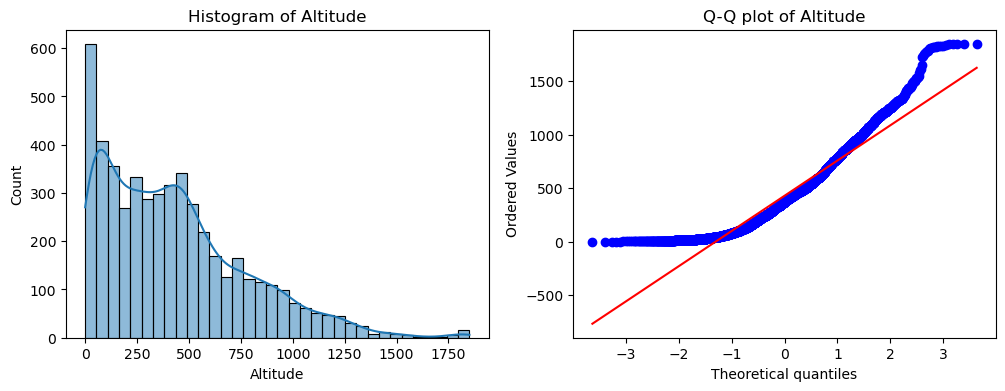

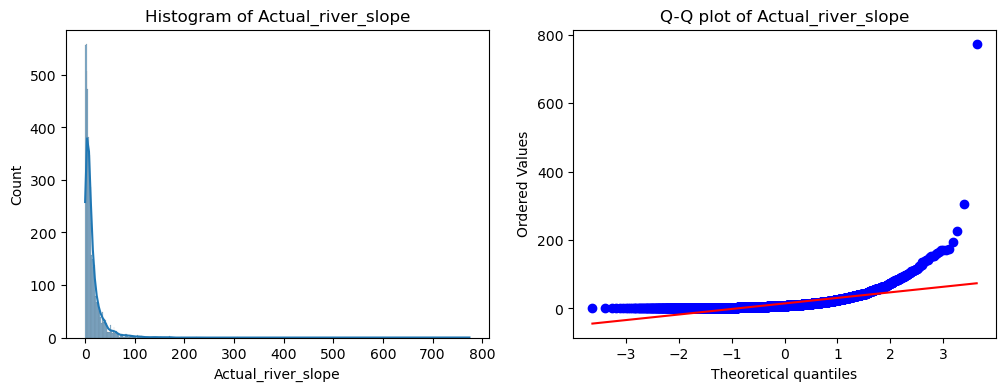

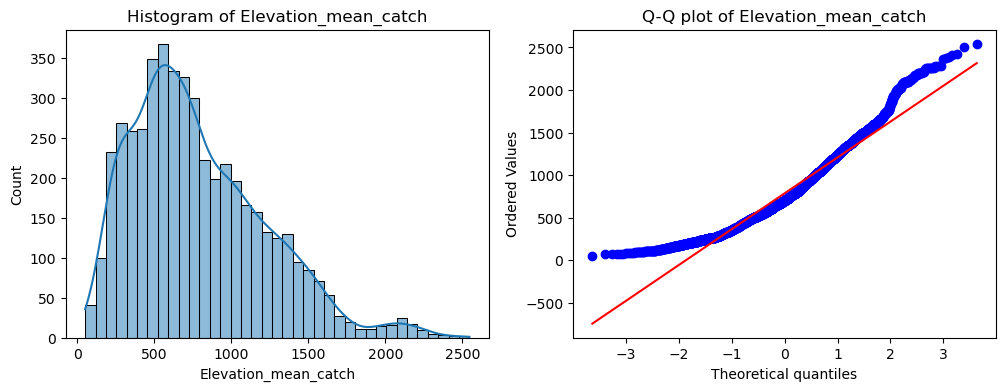

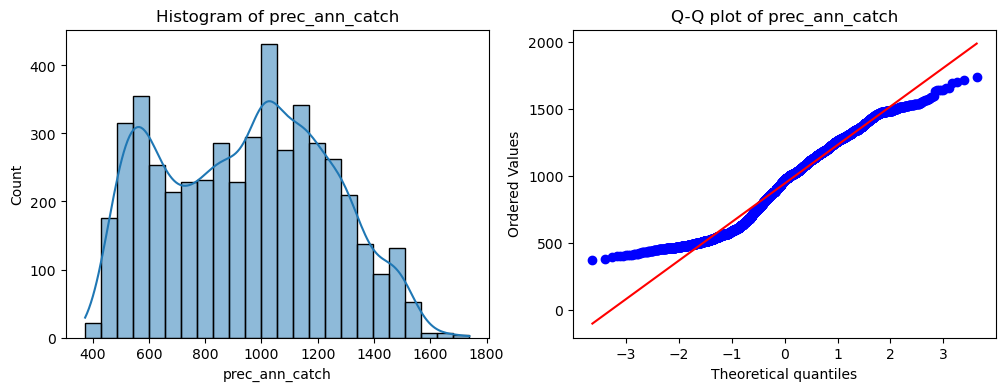

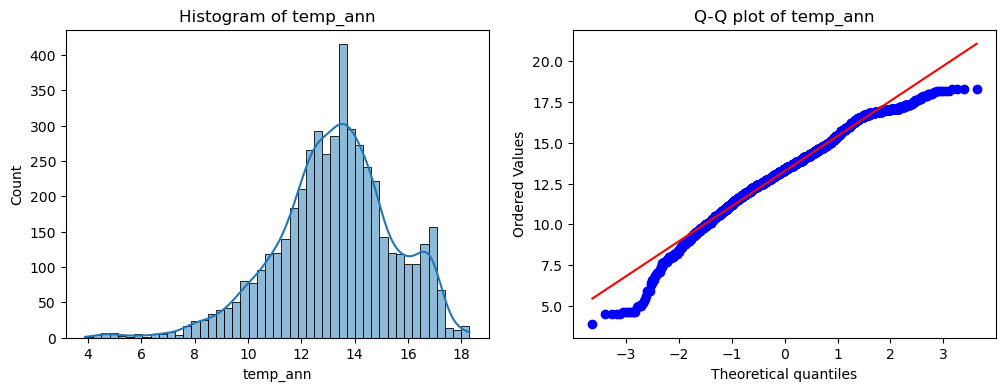

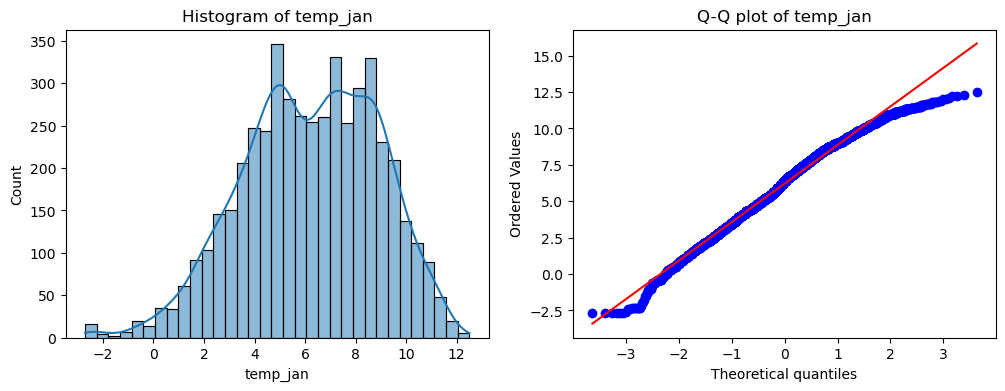

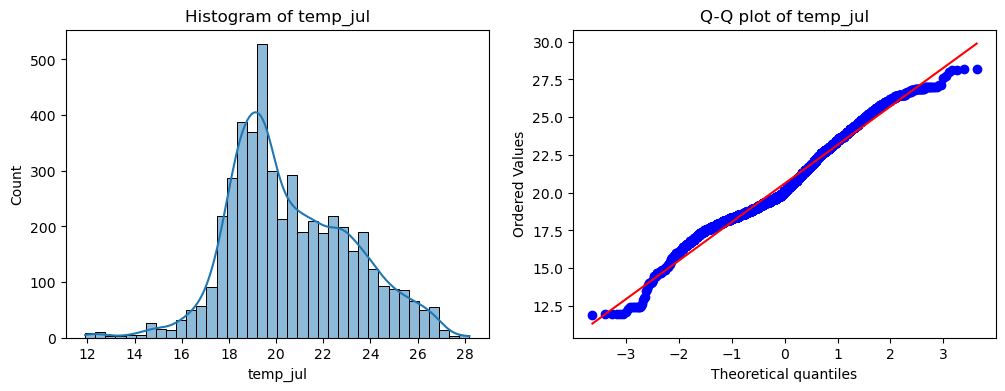

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from scipy.stats import shapiro
from scipy.stats import boxcox
from scipy.special import boxcox1p

# Load dataset
df = pd.read_csv('EFIplus_medit.csv', sep=';')

cont_vars = ['Altitude', 'Actual_river_slope', 'Elevation_mean_catch', 
             'prec_ann_catch', 'temp_ann', 'temp_jan', 'temp_jul']

# Plot histograms and Q-Q plots to check normality visually
import scipy.stats as stats

for var in cont_vars:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(df[var].dropna(), kde=True)
    plt.title(f'Histogram of {var}')
    
    plt.subplot(1,2,2)
    stats.probplot(df[var].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q plot of {var}')
    plt.show()

After analyzing we can conclude that tranformations are required since all of the columns don't have an apparent normal distribution.

### 2. Apply the appropriate data transformation and check the new distributions.

To find the appropriate transformation, 

Altitude contains zero or negative values, using Yeo-Johnson or log1p transformation
Actual_river_slope contains zero or negative values, using Yeo-Johnson or log1p transformation
Elevation_mean_catch is positive, Box-Cox transformation applicable
prec_ann_catch is positive, Box-Cox transformation applicable
temp_ann is positive, Box-Cox transformation applicable
temp_jan contains zero or negative values, using Yeo-Johnson or log1p transformation
temp_jul is positive, Box-Cox transformation applicable


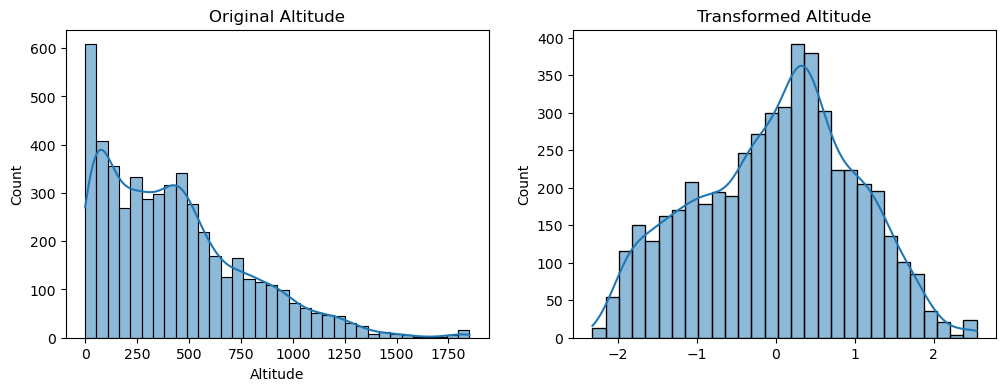

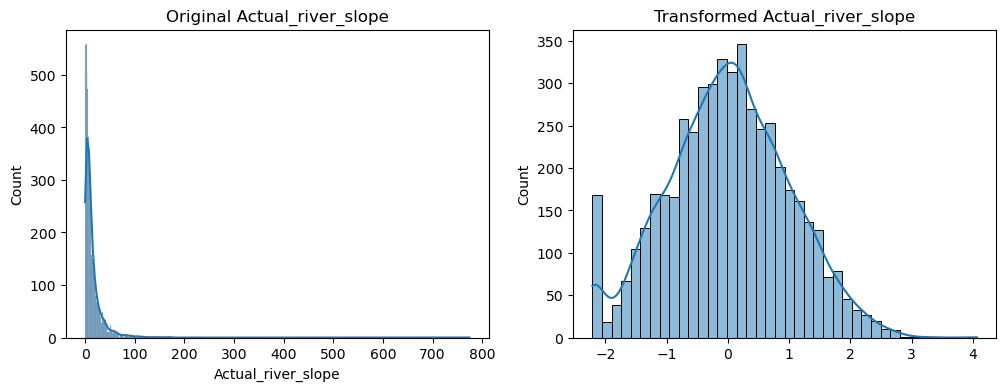

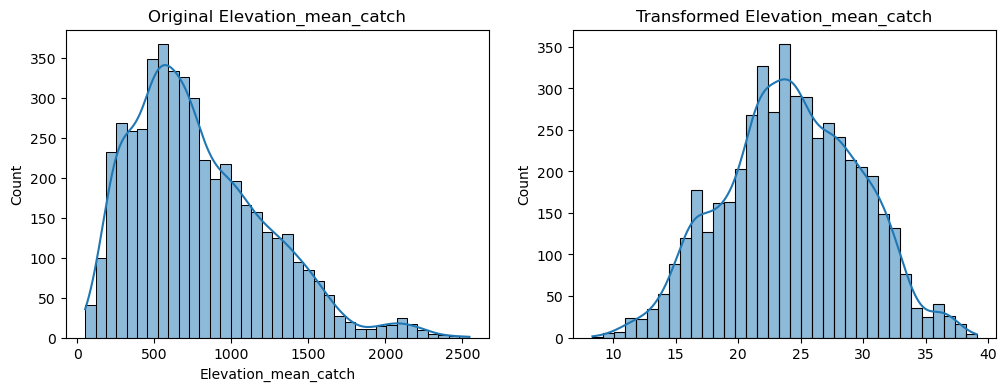

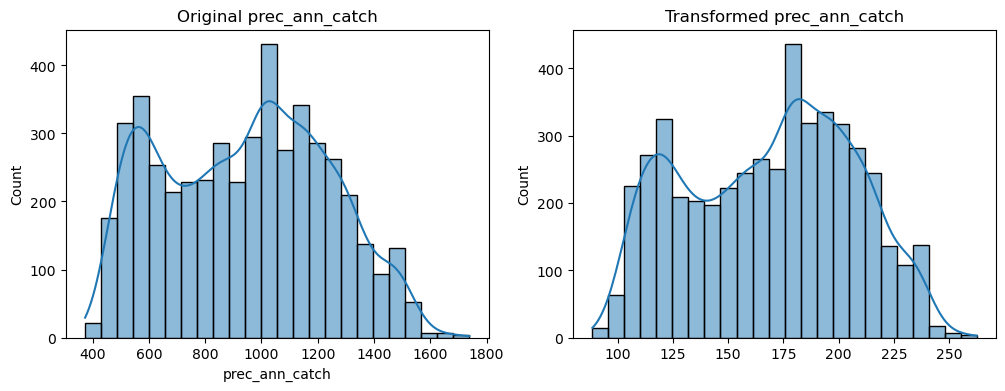

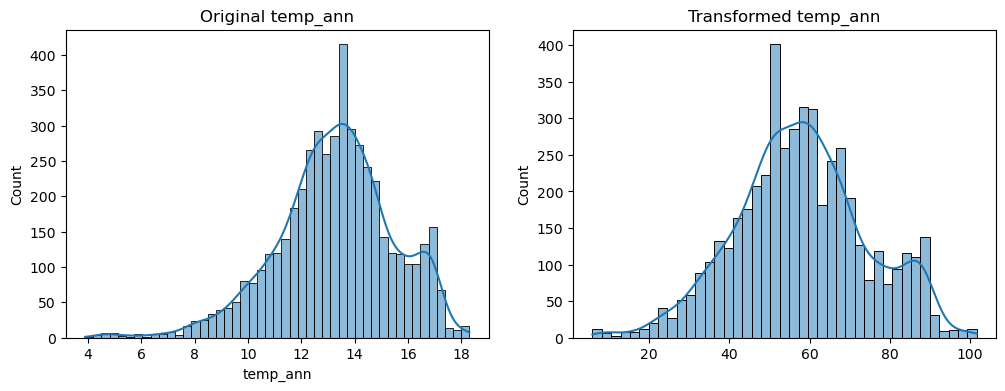

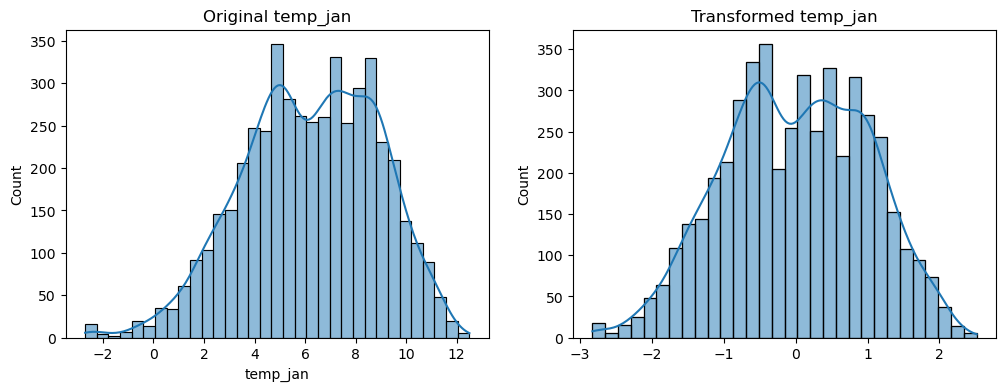

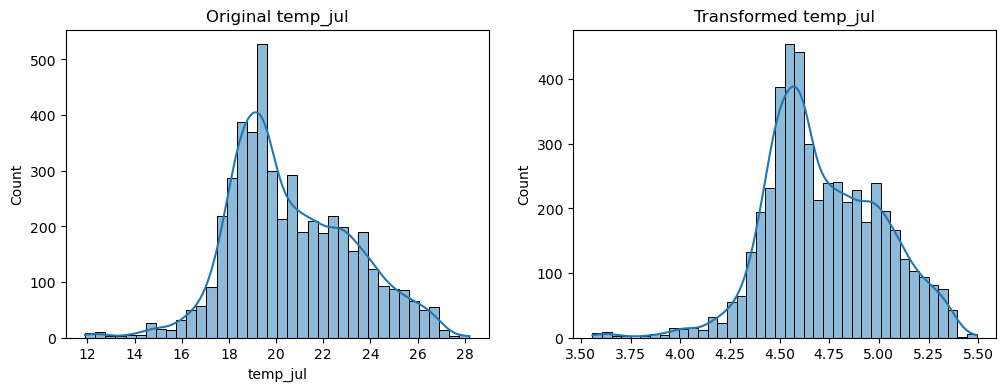

In [21]:
# We will use Box-Cox transformation for positive variables, otherwise log1p or Yeo-Johnson.
# First, check if variables are positive (Box-Cox requires positive data)
for var in cont_vars:
    if (df[var] <= 0).any():
        print(f"{var} contains zero or negative values, using Yeo-Johnson or log1p transformation")
    else:
        print(f"{var} is positive, Box-Cox transformation applicable")

# For this exercise, let's apply Box-Cox where possible, else Yeo-Johnson (scipy boxcox1p)
transformed_vars = {}
for var in cont_vars:
    data = df[var].dropna()
    if (data <= 0).any():
        # Use Yeo-Johnson (boxcox1p with lambda=None)
        # boxcox1p(x, lmbda) applies (x+1)^lmbda - 1 / lmbda if lmbda != 0
        # but scipy's boxcox1p requires lambda given, so we use power transform from sklearn instead
        from sklearn.preprocessing import PowerTransformer
        pt = PowerTransformer(method='yeo-johnson')
        transformed = pt.fit_transform(data.values.reshape(-1,1)).flatten()
        transformed_vars[var] = (transformed, pt)
    else:
        # Box-Cox transform
        transformed, lmbda = boxcox(data)
        transformed_vars[var] = (transformed, lmbda)

# Plot transformed distributions
for var in cont_vars:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(df[var].dropna(), kde=True)
    plt.title(f'Original {var}')
    plt.subplot(1,2,2)
    trans_data = transformed_vars[var][0]
    sns.histplot(trans_data, kde=True)
    plt.title(f'Transformed {var}')
    plt.show()

### 3. Create a column with the total number of species present (the species richness) in each sampling site (NOTE: the first species in the dataset is ‘Abramis brama’ and all the columns to the right correspond to species presence/absence).

In [ ]:
species_start_col = df.columns.get_loc('Abramis brama') if 'Abramis brama' in df.columns else None

species_cols = df.columns[species_start_col:]

# Sum presence (1) across species columns for each site
df['species_richness'] = df[species_cols].sum(axis=1)
print(df.head())

    Site_code   Latitude  Longitude Country Catchment_name  Galiza  Subsample  \
0  ES_01_0002  38.102003  -4.096070   Spain   Guadalquivir       0          1   
1  ES_02_0001  40.530188  -1.887796   Spain           Tejo       0          1   
2  ES_02_0002  40.595432  -1.928079   Spain           Tejo       0          1   
3  ES_02_0003  40.656184  -1.989831   Spain           Tejo       0          1   
4  ES_02_0004  40.676402  -2.036274   Spain           Tejo       0          1   

   Calib_EFI_Medit  Calib_connect  Calib_hydrol  ...  Squalius pyrenaicus  \
0                0              1             0  ...                    0   
1                1              1             1  ...                    0   
2                1              1             1  ...                    0   
3                1              1             1  ...                    0   
4                1              1             1  ...                    0   

   Squalius torgalensis  Thymallus thymallus  Tinc

### 4. Check the existence of bivariate outliers in the relationship between Mean Annual Temperature (‘temp_ann’) and species richness using an appropriate plot. Run a bivariate isolation forest to detect outliers and plot the result.

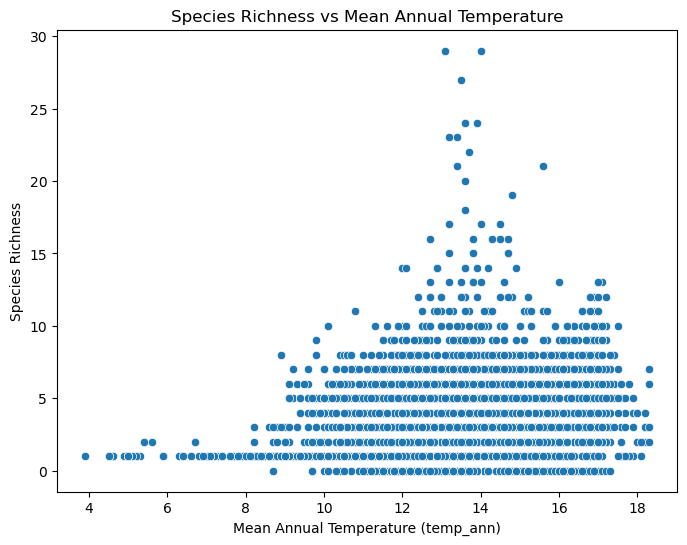

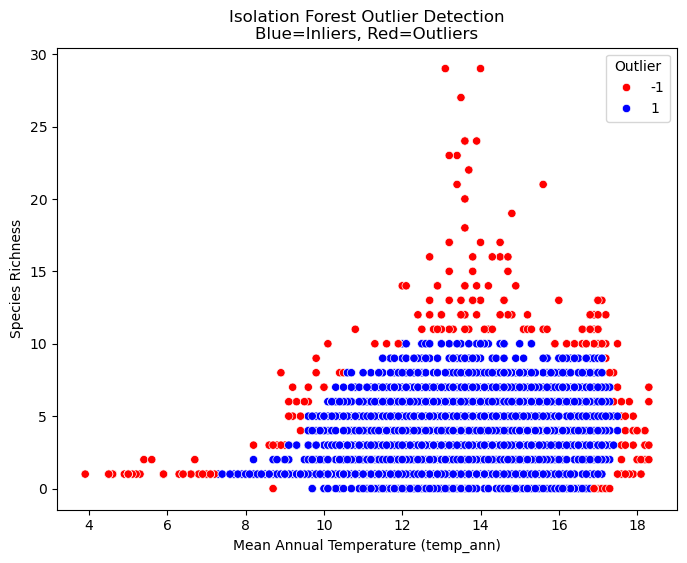

In [23]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='temp_ann', y='species_richness', data=df)
plt.title('Species Richness vs Mean Annual Temperature')
plt.xlabel('Mean Annual Temperature (temp_ann)')
plt.ylabel('Species Richness')
plt.show()

# Isolation Forest for bivariate outlier detection
X = df[['temp_ann', 'species_richness']].dropna()
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(X)

# Plot with outliers highlighted
plt.figure(figsize=(8,6))
palette = {1:'blue', -1:'red'}
sns.scatterplot(x=X['temp_ann'], y=X['species_richness'], hue=outliers, palette=palette)
plt.title('Isolation Forest Outlier Detection\nBlue=Inliers, Red=Outliers')
plt.xlabel('Mean Annual Temperature (temp_ann)')
plt.ylabel('Species Richness')
plt.legend(title='Outlier')
plt.show()

### 5. Explore visually, using a single plot, if this relationship (temp_ann x species richness) may vary across countries.

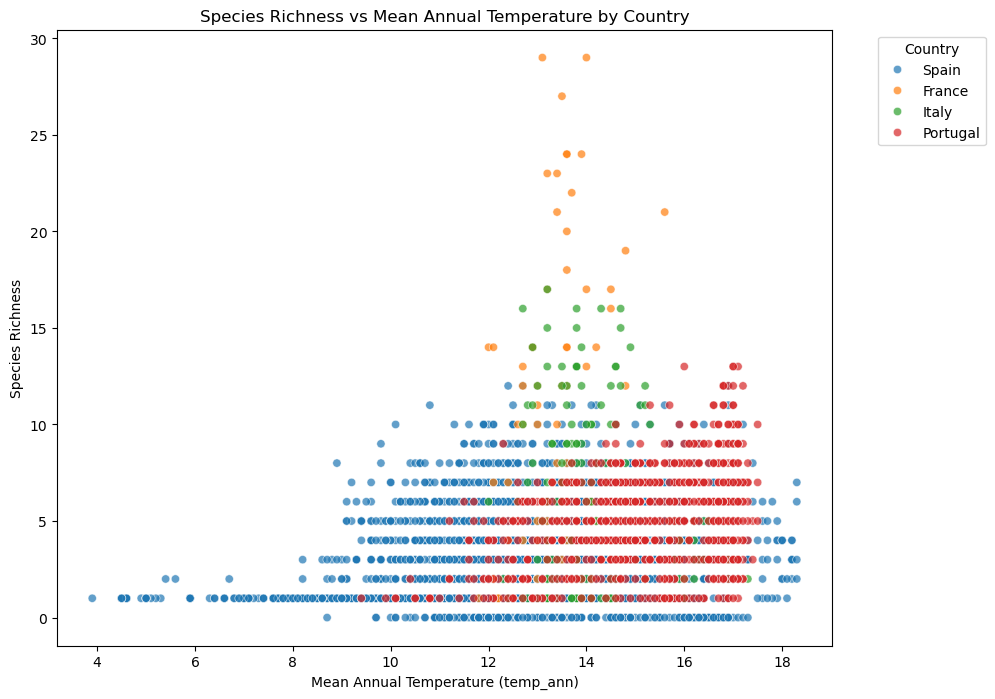

In [24]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='temp_ann', y='species_richness', hue='Country', data=df, alpha=0.7)
plt.title('Species Richness vs Mean Annual Temperature by Country')
plt.xlabel('Mean Annual Temperature (temp_ann)')
plt.ylabel('Species Richness')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()